## Instal requirements

In [ ]:
!pip install transformers
!pip install fastBPE
!pip install fairseq
!pip install vncorenlp
!pip install scikit-learn

In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/


In [ ]:
!wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
!tar -xzvf PhoBERT_base_transformers.tar.gz
!rm -rf PhoBERT_base_transformers.tar.gz

In [ ]:
!wget https://public.vinai.io/PhoBERT_large_transformers.tar.gz
!tar -xzvf PhoBERT_large_transformers.tar.gz
!rm -rf PhoBERT_large_transformers.tar.gz

In [ ]:
!wget https://public.vinai.io/PhoBERT_base_fairseq.tar.gz
!tar -xzvf PhoBERT_base_fairseq.tar.gz
!rm -rf PhoBERT_base_fairseq.tar.gz

## Import dependencies

In [27]:
import pandas as pd
import re
import sqlite3
import string
import pickle
import seaborn as sns
from vncorenlp import VnCoreNLP
from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary
import argparse
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import random
import time
# from tqdm import tqdm_notebook
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler


In [28]:
conn_train = sqlite3.connect("../Data/generate_data/data_train.db")
crs_train = conn_train.cursor()
data_train = pd.read_sql_query("SELECT * FROM data", conn_train) 

conn_test = sqlite3.connect("../Data/generate_data/data_test.db")
crs_test = conn_test.cursor()
data_test = pd.read_sql_query("SELECT * FROM data", conn_test)


In [29]:
train_data = pd.DataFrame()
train_data['title'] = data_train.Posts
train_data['label'] = data_train['Emotion']

test_data = pd.DataFrame()
test_data['title'] = data_test.Posts
test_data['label'] = data_test['Emotion']

<AxesSubplot:xlabel='label', ylabel='count'>

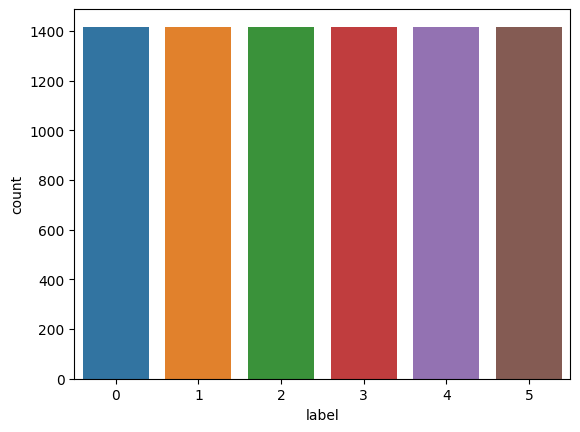

In [30]:
sns.countplot(data=train_data, x='label')

In [31]:
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

2022-11-07 18:44:30 | INFO | vncorenlp.vncorenlp | Starting server on: http://127.0.0.1:58101
2022-11-07 18:44:30 | INFO | vncorenlp.vncorenlp | Server ID: 47965
2022-11-07 18:44:30 | INFO | vncorenlp.vncorenlp | Waiting until the server is available...
2022-11-07 18:44:35 | INFO | vncorenlp.vncorenlp | The server is now available on: http://127.0.0.1:58101


In [32]:
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="./PhoBERT_base_transformers/bpe.codes",
    # default="./PhoBERT_large_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file("./PhoBERT_base_transformers/dict.txt")
# vocab.add_from_file("./PhoBERT_large_transformers/dict.txt")

Loading codes from ./PhoBERT_base_transformers/bpe.codes ...
Read 64000 codes from the codes file.


In [33]:
def removeStopWord():
   f = open("../StopWords/vietnamese-stopwords-dash.txt", "r")
   stopWords = f.readlines()
   for idx,line  in enumerate(stopWords):
      stopWords[idx] = line.replace("\n", "").strip()
      if (len(stopWords[idx]) <= 0):
         stopWords.pop(idx)
   return stopWords

stopWords = removeStopWord()

In [34]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


In [35]:
with open('../Emoticon_Dict.p', 'rb') as fp:
    Emoticon_Dict = pickle.load(fp)

def remove_emoticons(text):
    emoticon_pattern = re.compile(
        u'(' + u'|'.join(k for k in Emoticon_Dict) + u')')
    return emoticon_pattern.sub(r'', text)


In [ ]:
train_text = train_data['title'].to_list()
train_labels = train_data['label'].to_list()
train_text = [re.sub(r'^\s+|\s+$', '', str(t)) for t in train_text]
train_text = [str(t).strip() for t in train_text]
train_text = [re.sub(r'\s\s+', ' ', str(t)) for t in train_text]
train_text = [re.sub(r'\n', ' ', str(t)) for t in train_text]
train_text = [re.sub(r'\d+', '', str(t)) for t in train_text]
train_text = [re.sub(r'http\S+', '', str(t)) for t in train_text]
train_text = [remove_emoji(str(t)) for t in train_text]
train_text = [remove_emoticons(str(t)) for t in train_text]
train_text = [rdrsegmenter.tokenize(t) for t in train_text]
for idx, text in enumerate(train_text):
   for idx2, text2 in enumerate(text):
         for idx3, text3 in enumerate(text2):
            if text3 in stopWords:
               text2.pop(idx3)
         if len(text2) <= 0:
            text.pop(idx2)
   if len(text) <= 0:
      train_text.pop(idx)
      train_labels.pop(idx)
for idx, text in enumerate(train_text):
   tmp = []
   for idx2, text2 in enumerate(text):
      tmp2 = []
      for idx3, text3 in enumerate(text2):
         if not text3.startswith("'") and text3 not in string.punctuation:
            tmp2.append(" "+text3)
         else:
            tmp2.append(text3)
         # if text3 not in string.punctuation:
         #    tmp2.append(" "+text3)
      tmp.append("".join(tmp2).strip())
   train_text[idx] = " ".join(tmp).strip()
# train_text = [str(t).lower() for t in train_text]

test_text = test_data['title'].to_list()
test_labels = test_data['label'].to_list()
test_text = [re.sub(r'^\s+|\s+$', '', str(t)) for t in test_text]
test_text = [str(t).strip() for t in test_text]
test_text = [re.sub(r'\s\s+', ' ', str(t)) for t in test_text]
test_text = [re.sub(r'\n', ' ', str(t)) for t in test_text]
test_text = [re.sub(r'\d+', '', str(t)) for t in test_text]
test_text = [re.sub(r'http\S+', '', str(t)) for t in test_text]
test_text = [remove_emoji(str(t)) for t in test_text]
test_text = [remove_emoticons(str(t)) for t in test_text]
test_text = [rdrsegmenter.tokenize(t) for t in test_text]
for idx, text in enumerate(test_text):
   for idx2, text2 in enumerate(text):
         for idx3, text3 in enumerate(text2):
            if text3 in stopWords:
               text2.pop(idx3)
         if len(text2) <= 0:
            text.pop(idx2)
   if len(text) <= 0:
      test_text.pop(idx)
      test_labels.pop(idx)
for idx, text in enumerate(test_text):
   tmp = []
   for idx2, text2 in enumerate(text):
      tmp2 = []
      for idx3, text3 in enumerate(text2):
         if not text3.startswith("'") and text3 not in string.punctuation:
            tmp2.append(" "+text3)
         else:
            tmp2.append(text3)
         # if text3 not in string.punctuation:
         #    tmp2.append(" "+text3)
      tmp.append("".join(tmp2).strip())
   test_text[idx] = " ".join(tmp).strip()
# test_text = [str(t).lower() for t in test_text]

In [37]:
train_sents = train_text
train_labels = train_labels
val_sents = test_text
val_labels = test_labels

In [38]:
MAX_LEN = 128

train_ids = []
for sent in train_sents:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    train_ids.append(encoded_sent)

val_ids = []
for sent in val_sents:
    subwords = '<s> ' + bpe.encode(sent) + ' </s>'
    encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
    val_ids.append(encoded_sent)
    
train_ids = pad_sequences(train_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
val_ids = pad_sequences(val_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

In [ ]:
train_masks = []
for sent in train_ids:
    mask = [int(token_id > 0) for token_id in sent]
    train_masks.append(mask)

val_masks = []
for sent in val_ids:
    mask = [int(token_id > 0) for token_id in sent]
    val_masks.append(mask)

In [ ]:

# device = torch.device("mps" if torch.has_mps else "cpu")
device = "cpu"
train_inputs = torch.tensor(train_ids, device=device)
val_inputs = torch.tensor(val_ids, device=device)
train_labels = torch.tensor(train_labels, device=device)
val_labels = torch.tensor(val_labels, device=device)
train_masks = torch.tensor(train_masks, device=device)
val_masks = torch.tensor(val_masks, device=device)

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=50)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=50)

In [ ]:
config = RobertaConfig.from_pretrained(
    "./PhoBERT_base_transformers/config.json"
    # "./PhoBERT_large_transformers/config.json"
    , from_tf=False, num_labels = 6, output_hidden_states=False
)
BERT_SA = RobertaForSequenceClassification.from_pretrained(
    "./PhoBERT_base_transformers/model.bin",
    # "./PhoBERT_large_transformers/model.bin",
    config = config
)

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at ./PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenc

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    F1_score = f1_score(pred_flat, labels_flat, average='macro')
    
    return accuracy_score(pred_flat, labels_flat), F1_score

In [ ]:
# device = torch.device("mps" if torch.has_mps else "cpu")
device = "cpu"
epochs = 5
max = 0

param_optimizer = list(BERT_SA.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0},
    {'params': [p for n, p in param_optimizer if any(
        nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=5e-7, correct_bias=False)

echo = []
acc = []
acc_val = []
av_loss = []
f1 = []
f1_val = []
start_time = time.time()
e = 0
for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    echo.append(epoch_i)

    total_loss = 0
    BERT_SA.train()
    train_accuracy = 0
    nb_train_steps = 0
    train_f1 = 0

    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # print(b_labels)
        BERT_SA.zero_grad()
        outputs = BERT_SA(b_input_ids,
                          token_type_ids=None,
                          attention_mask=b_input_mask,
                          labels=b_labels)
        loss = outputs[0]
        # print(outputs)
        total_loss += loss.item()

        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_train_accuracy, tmp_train_f1 = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        train_f1 += tmp_train_f1
        nb_train_steps += 1

        loss.backward()
        torch.nn.utils.clip_grad_norm_(BERT_SA.parameters(), 1.0)
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)

    print(" Accuracy: {0:.4f}".format(train_accuracy/nb_train_steps))
    acc.append(float("{:.4f}".format(train_accuracy/nb_train_steps)))

    print(" F1 score: {0:.4f}".format(train_f1/nb_train_steps))
    f1.append(float("{:.4f}".format(train_f1/nb_train_steps)))

    print(" Average training loss: {0:.4f}".format(avg_train_loss))
    av_loss.append(float("{:.4f}".format(avg_train_loss)))

    BERT_SA.save_pretrained('./model/{}'.format(epoch_i+1))
    print("Running Validation...")
    BERT_SA.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    eval_f1 = 0
    for batch in tqdm(val_dataloader, total=len(val_dataloader)):

        batch = tuple(t.to(device) for t in batch)

        b_input_ids, b_input_mask, b_labels = batch
        # print(b_labels)

        with torch.no_grad():
            outputs = BERT_SA(b_input_ids,
                              token_type_ids=None,
                              attention_mask=b_input_mask)
            logits = outputs[0]
            # loss_val=outputs[0]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # print(logits)
            # print(label_ids)

            tmp_eval_accuracy, tmp_eval_f1 = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            eval_f1 += tmp_eval_f1
            nb_eval_steps += 1
    if max < eval_accuracy/nb_eval_steps:
        max = eval_accuracy/nb_eval_steps
        e = epoch_i
    print('logits:    {}'.format(np.argmax(logits, axis=1).flatten()))
    print('labels_id: {}'.format(label_ids))

    print(" Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    acc_val.append(float("{:.4f}".format(eval_accuracy/nb_eval_steps)))

    print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))
    f1_val.append(float("{:.4f}".format(eval_f1/nb_eval_steps)))
print("Training complete!")
print('Best Valid acc : {}, epoch: {}'.format(max, e+1))
end_time = time.time()
elapsed_time = end_time - start_time
print("elapsed_time:{0}".format(elapsed_time) + "[sec]")


======== Epoch 1 / 5 ========
Training...


/Users/maddie/Desktop/DATN/HoangPhiLong/Code/env/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/170 [00:00<?, ?it/s]

 Accuracy: 0.1766
 F1 score: 0.1560
 Average training loss: 1.7932
Running Validation...


  0%|          | 0/31 [00:00<?, ?it/s]

logits:    [1]
labels_id: [1]
 Accuracy: 0.1929
 F1 score: 0.1805
======== Epoch 2 / 5 ========
Training...


  0%|          | 0/170 [00:00<?, ?it/s]

 Accuracy: 0.1719
 F1 score: 0.1616
 Average training loss: 1.7920
Running Validation...


  0%|          | 0/31 [00:00<?, ?it/s]

logits:    [1]
labels_id: [3]
 Accuracy: 0.1542
 F1 score: 0.1402
======== Epoch 3 / 5 ========
Training...


  0%|          | 0/170 [00:00<?, ?it/s]

 Accuracy: 0.1858
 F1 score: 0.1755
 Average training loss: 1.7870
Running Validation...


  0%|          | 0/31 [00:00<?, ?it/s]

logits:    [5]
labels_id: [5]
 Accuracy: 0.1916
 F1 score: 0.1705
======== Epoch 4 / 5 ========
Training...


  0%|          | 0/170 [00:00<?, ?it/s]

 Accuracy: 0.1834
 F1 score: 0.1726
 Average training loss: 1.7850
Running Validation...


  0%|          | 0/31 [00:00<?, ?it/s]

logits:    [2]
labels_id: [1]
 Accuracy: 0.1710
 F1 score: 0.1476
======== Epoch 5 / 5 ========
Training...


  0%|          | 0/170 [00:00<?, ?it/s]

 Accuracy: 0.1968
 F1 score: 0.1795
 Average training loss: 1.7804
Running Validation...


  0%|          | 0/31 [00:00<?, ?it/s]

logits:    [2]
labels_id: [1]
 Accuracy: 0.1677
 F1 score: 0.1496
Training complete!
Best Valid acc : 0.19290322580645164, epoch: 1
elapsed_time:1316.4799537658691[sec]


### `***ACC, F1, Loss***`
echo = []
acc = []
acc_val = []
av_loss = []
f1 = []
f1_val = []

In [ ]:
# echo_old = echo
# acc_old = acc
# acc_val_old = acc_val
# av_loss_old = av_loss
# f1_old = f1
# f1_val_old = f1_val

# echo_old.extend(echo)
# acc_old.extend(acc)
# acc_val_old.extend(acc_val)
# av_loss_old = av_loss
# f1_old = f1
# f1_val_old = f1_val

# print(echo_old)
# print(acc_old)
# print(acc_val_old) 
# print(av_loss_old) 
# print(f1_old) 
# print(f1_val_old) 

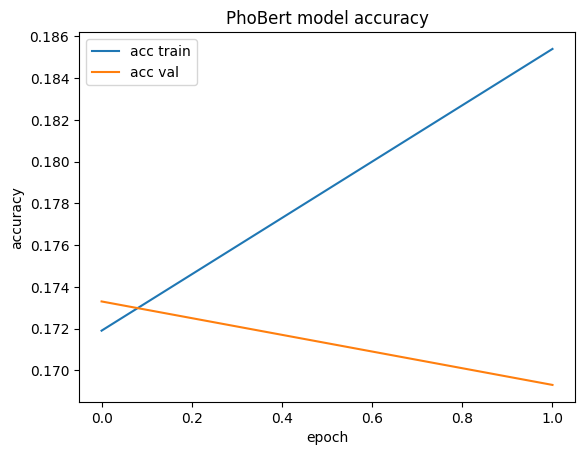

In [ ]:
#ACC train and val
plt.plot(echo,acc)
plt.plot(echo,acc_val)
plt.title('PhoBert model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc train', 'acc val'], loc='upper left')
plt.savefig('./result/ModelV1/acc_200e_6Label_base.png',bbox_inches='tight')
plt.show()

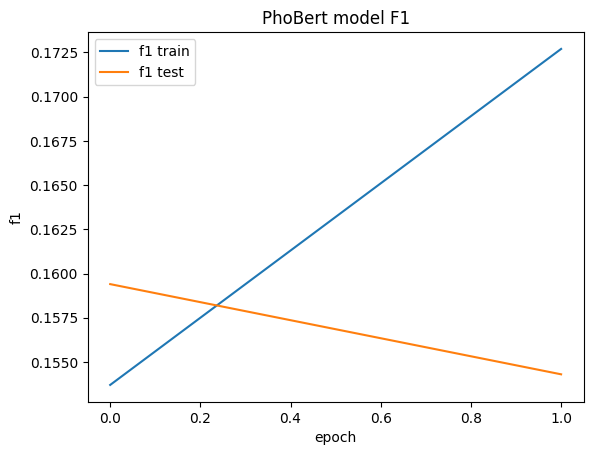

In [ ]:
#F1 train and val
plt.plot(echo,f1)
plt.plot(echo,f1_val)
plt.title('PhoBert model F1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['f1 train', 'f1 test'], loc='upper left')
plt.savefig('./result/ModelV1/f1_200e_6Label_base.png', bbox_inches='tight')
plt.show()

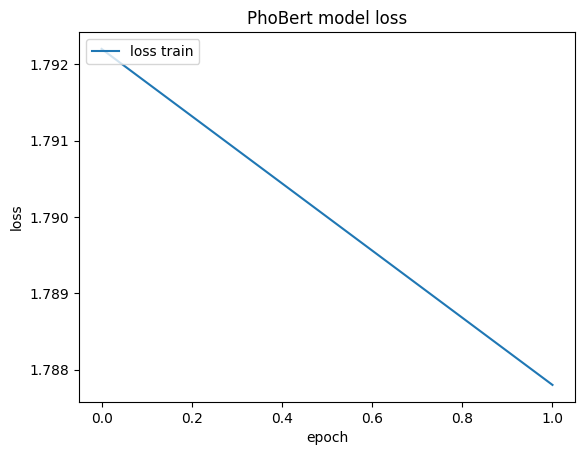

In [ ]:
#Loss

plt.plot(echo,av_loss)
# plt.plot(echo,y1)
plt.title('PhoBert model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss train'], loc='upper left')
plt.savefig('./result/ModelV1/loss_200e_6Label_base.png', bbox_inches='tight')
plt.show()

In [ ]:
!zip -r ./model.zip ./Deep/modelbert/5

# ***Test***

In [ ]:
path_config = './model/9/config.json'
path_model = './model/9/pytorch_model.bin'
path_bpe = './PhoBERT_base_transformers/bpe.codes'
path_vocab = './PhoBERT_base_transformers/dict.txt'

def get_model(path_model= None, path_config = None, path_bpe = None, path_vocab = None):
  config = RobertaConfig.from_pretrained(
      path_config, from_tf=False, num_labels = 8, output_hidden_states=False
  )
  BERT_SA_NEW = RobertaForSequenceClassification.from_pretrained(
      path_model,
      ignore_mismatched_sizes=True,
      config=config
  )
  # BERT_SA_NEW.cuda()
  BERT_SA_NEW.eval()


  try:
    parser = argparse.ArgumentParser()
    parser.add_argument('--bpe-codes', 
        default=path_bpe,
        required=False,
        type=str,
        help='path to fastBPE BPE'
    )
    args, unknown = parser.parse_known_args()
    bpe = fastBPE(args)
  except:
    bpe = None
    print("load bpe fail")

  try:
    vocab = Dictionary()
    vocab.add_from_file(path_vocab)
  except:
    vocab=None
    print('load vocab fail')
  return BERT_SA_NEW, bpe, vocab

model, bpe, vocab = get_model(path_model, path_config, path_bpe, path_vocab)

In [ ]:
def predict(model, bpe, sense, vocab):
  subwords = '<s> ' + bpe.encode(sense) + ' </s>'
  encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
  encoded_sent = pad_sequences([encoded_sent], maxlen=195, dtype="long", value=0, truncating="post", padding="post")
  mask = [int(token_id > 0) for token_id in encoded_sent[0]]


  # encoded_sent = torch.tensor(encoded_sent).cuda()
  # mask = torch.tensor(mask).cuda()
  encoded_sent = torch.tensor(encoded_sent)
  mask = torch.tensor(mask)
  encoded_sent = torch.reshape(encoded_sent, (1, 195))
  mask = torch.reshape(mask, (1, 195))

  with torch.no_grad():
    outputs = model(encoded_sent, 
      token_type_ids=None, 
      attention_mask=mask)
    logits = outputs[0]
  return int(torch.argmax(logits))

In [ ]:
sent = 'một lí do trong muôn vàn lí do'
predict(model, bpe, sent, vocab)